In [213]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [214]:
import os
import cv2
import calib_camera
from calib_camera import find_obj_and_img_points, calibrate_camera
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np

#### Step 1: Camera Calibration

In [1]:
# calib_camera.logger.setLevel("DEBUG")

In [3]:
nx = 9
ny = 6
images = glob.glob("camera_cal/calibration*.jpg")
pickle_file = "camera_cal/dist_pickle.p"

In [4]:
# Find object and image points and use these to calibrate the camera
objpoints, imgpoints = find_obj_and_img_points(images, nx, ny)
mtx, dist = calibrate_camera(objpoints, imgpoints, (1280, 720))

# save required variables in a pickle file
dict_pickle = dict(objpoints=objpoints, imgpoints=imgpoints, mtx=mtx, dist=dist)
pickle.dump(dict_pickle, open(pickle_file, "wb"))

2019-09-26 14:15:03,727 - CalibCamera - INFO - Found corners on 17 images
2019-09-26 14:15:04,734 - CalibCamera - INFO - Returned mtx and dist from camera calibration


#### Step 2: Undistort and transform perspective

Let's use one image as an example and transform that into a bird-eye view

In [215]:
from pipeline import perspective_transform

straight_lines1.jpg


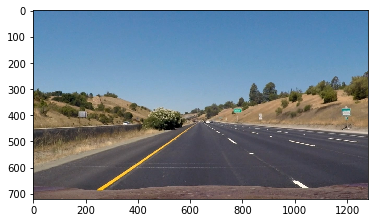

In [404]:
fnames = os.listdir("test_images")
idx = 7
fname = fnames[idx]
print(fname)
img = cv2.imread(os.path.join("test_images", fname))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [275]:
# first load mtx and dist
pickle_file = "camera_cal/dist_pickle.p"
dict_pickle = pickle.load(open(pickle_file, "rb"))
mtx, dist = dict_pickle["mtx"], dict_pickle["dist"]

In [248]:
# warp to birds eye-view
src = np.float32([[490, 482],
                  [810, 482],
                  [1250, 720],
                  [40, 720]])
dst = np.float32([[0, 0], 
                  [1280, 0], 
                  [1250, 720],
                  [40, 720]])

src = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right

dst = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   

In [249]:
img_size = (img.shape[1], img.shape[0])
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

In [405]:
# counter clockwise: top left, bottom left, bottom right, top right
src = np.float32(
      [[ 585,  460],
       [ 203,  720],
       [1126,  720],
       [ 695,  460]])

dst = np.float32(
      [[320,   0.],
       [320, 720.],
       [960, 720.],
       [960,   0.]])

In [406]:
warped_img, M = perspective_transform(img, mtx, dist, src, dst, img_size=(img.shape[1], img.shape[0]))

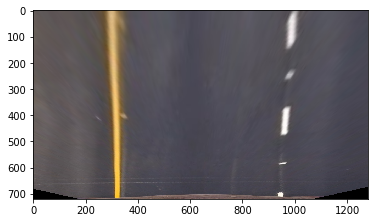

In [407]:
plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))  # seems plausible

In [ ]:
# Testing undistort

# images = glob.glob('camera_cal/calibration*.jpg')
# idx = 1
# fname = images[idx]
# print(fname)
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# img = cv2.imread(fname)
# dst = cv2.undistort(img, mtx, dist, None, mtx)
# ax1.imshow(img)
# ax1.set_title('Original Image', fontsize=20)
# ax2.imshow(dst)
# ax2.set_title("Undistorted Image", fontsize=20)

#### Step 3: Color Thresholding

In [253]:
from pipeline import abs_sobel_thresh, dir_thresh, mag_thresh, hls_thresh

In [408]:
grad_binary = abs_sobel_thresh(warped_img, orient='x', thresh=(20, 100), sobel_kernel=3)
mag_binary = mag_thresh(warped_img, thresh=(30, 100), sobel_kernel=3)
dir_binary = dir_thresh(warped_img, thresh=(0.7, 1.3), sobel_kernel=15)
hls_binary = hls_thresh(warped_img, hls_channel="S", thresh=(90, 255))
assert grad_binary.shape == mag_binary.shape == dir_binary.shape == hls_binary.shape == warped_img.shape[:2] 

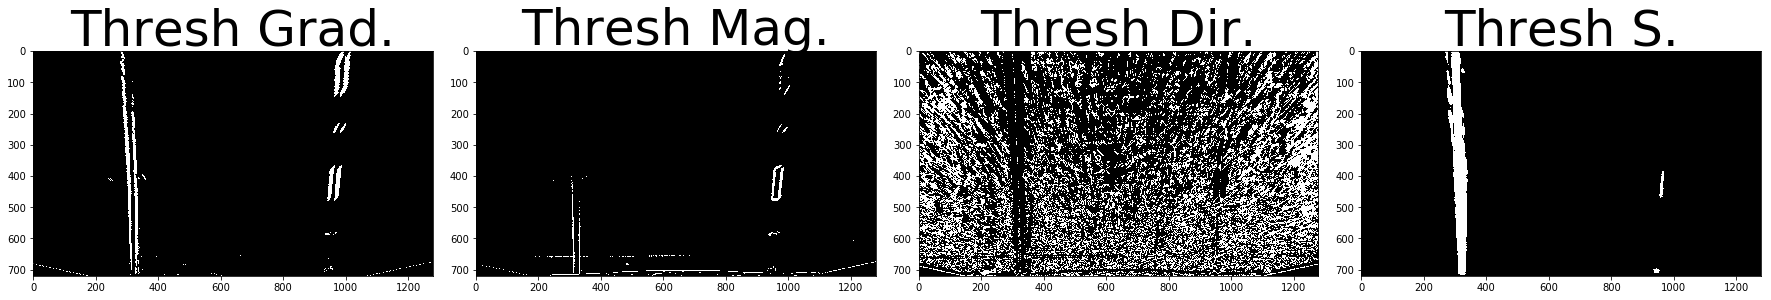

In [409]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(grad_binary, cmap="gray")
ax1.set_title('Thresh Grad.', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresh Mag.', fontsize=50)
ax3.imshow(dir_binary, cmap='gray')
ax3.set_title('Thresh Dir.', fontsize=50)
ax4.imshow(hls_binary, cmap='gray')
ax4.set_title('Thresh S.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [410]:
# Combine thresholds
combined_binary = np.zeros_like(dir_binary)
# combined_binary[(hls_binary == 1) | ((grad_binary == 1) | ((mag_binary == 1) & (dir_binary == 1)))] = 1
# combined_binary[(hls_binary == 1) | (mag_binary == 1)] = 1
combined_binary[(hls_binary == 1) | ( ((mag_binary == 1) & (dir_binary == 0)))] = 1

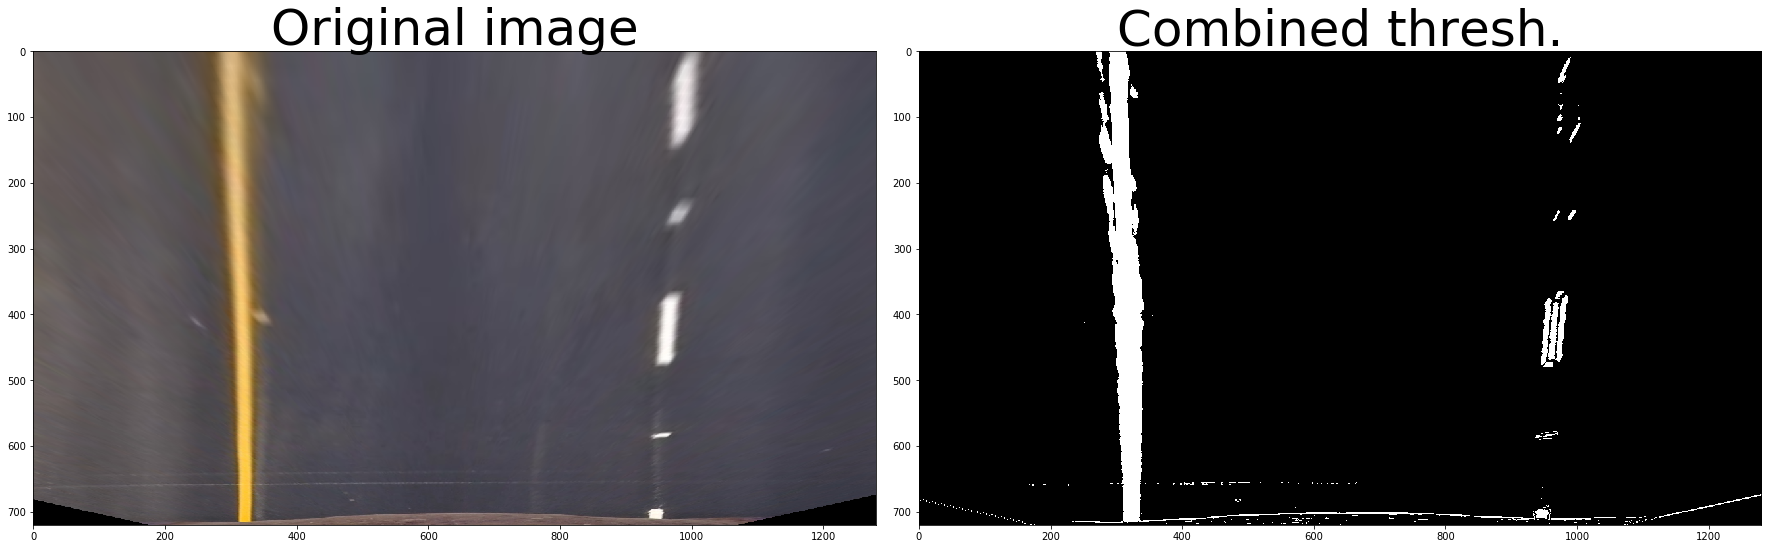

In [411]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined thresh.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Step 4: Find lane lines

In [412]:
def plt_images(img_1, title_1, img_2, title_2, cmap='gray'):
    # Visualize undirstorsion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(title_1, fontsize=16)
    ax1.imshow(img_1)
    ax2.set_title(title_2, fontsize=16)
    ax2.imshow(img_2, cmap='gray')

In [413]:
from pipeline import hist, find_lane_pixels, search_around_poly, fit_poly, fit_polynomial

In [414]:
# lets do it step by step
binary_warped = combined_binary
histogram = hist(binary_warped) # sum over pixel values of bottom half image -> peaks indicate lines
out_img = np.dstack((binary_warped, binary_warped, binary_warped)) # create output image to draw on (not necessary)
midpoint = np.int(histogram.shape[0]//2)  # 640
leftx_base = np.argmax(histogram[:midpoint])  # find index of left peak (indicates ll)
rightx_base = np.argmax(histogram[midpoint:]) + midpoint # find index of right peak (indicates rl)
nwindows = 9
margin = 100
minpix = 50
window_height = np.int(binary_warped.shape[0]//nwindows)  # 80
nonzero = binary_warped.nonzero()  # a tuple for x and y
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
leftx_current = leftx_base
rightx_current = rightx_base
left_lane_inds = []
right_lane_inds = []
for window in range(nwindows):  # index 0 to 8
    win_y_low = binary_warped.shape[0] - (window+1)*window_height  
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) # bottom left to top right, in green, with thickness 2
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
    good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) & 
            (nonzeroy >= win_y_low ) & (nonzeroy < win_y_high)).nonzero()[0]
    good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) & 
        (nonzeroy >= win_y_low ) & (nonzeroy < win_y_high)).nonzero()[0]
    left_lane_inds.append(good_left_inds)  # indices
    right_lane_inds.append(good_right_inds)
    if len(good_left_inds) > minpix:
        leftx_current = int(np.mean(nonzerox[good_left_inds]))
        # print(leftx_current)
    if len(good_right_inds) > minpix:
        rightx_current = int(np.mean(nonzerox[good_right_inds]))

left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

left_fit = np.polyfit(lefty, leftx, deg=2)
right_fit = np.polyfit(righty, rightx, deg=2)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
for index in range(binary_warped.shape[0]):
    cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
    cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


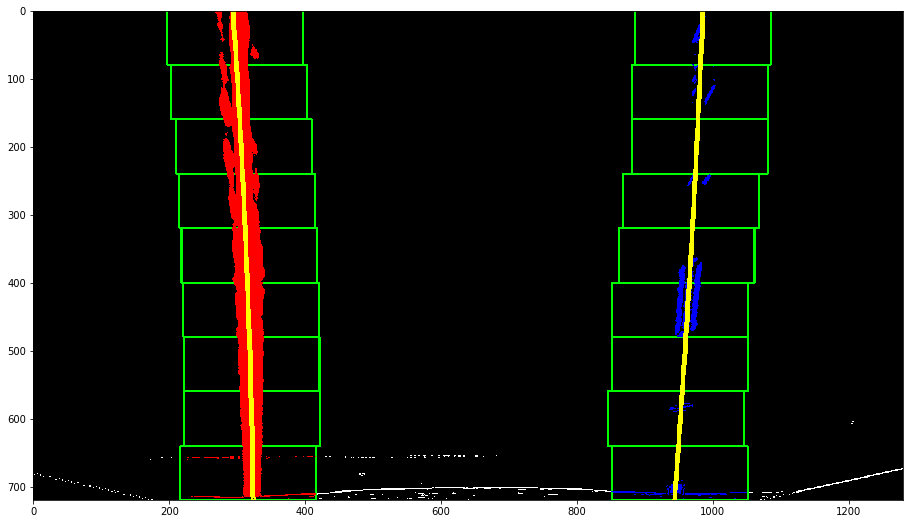

In [415]:
plt.figure(figsize=(24,9))
plt.imshow(out_img)

In [416]:
def search_around_poly(binary_warped):
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox >= left_fit[0]*nonzeroy**2 + 
        left_fit[1]*nonzeroy + left_fit[2] - margin) & 
        (nonzerox < left_fit[0]*nonzeroy**2 + 
        left_fit[1]*nonzeroy + left_fit[2] + margin)).nonzero()[0]
    right_lane_inds = ((nonzerox >= right_fit[0]*nonzeroy**2 + 
        right_fit[1]*nonzeroy + right_fit[2] - margin) & 
        (nonzerox < right_fit[0]*nonzeroy**2 + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)).nonzero()[0]
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
    ## End visualization steps ##
    
    return left_fitx, right_fitx, ploty, result

In [417]:
left_fitx, right_fitx, ploty, result = search_around_poly(binary_warped)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


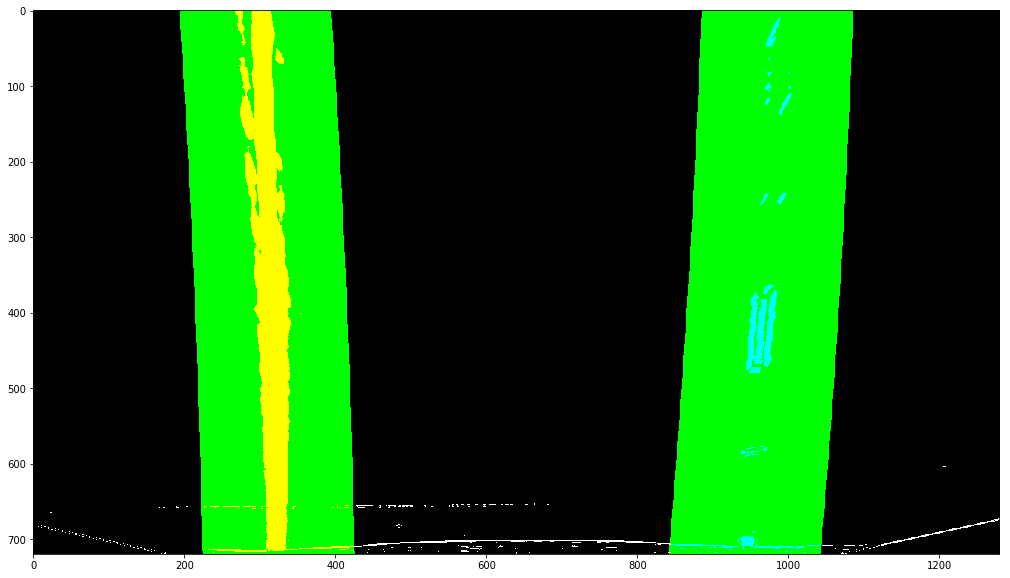

In [418]:
plt.figure(figsize=(24,10))
plt.imshow(result)

#### 5a. Measure curvature


In [419]:
def measure_curvature_real(ploty, left_fitx, right_fitx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fitx = left_fitx[::-1]
    right_fitx = right_fitx[::-1]
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1+(2*left_fit_cr[0]*y_eval*ym_per_pix+left_fit_cr[1])**2)**(3/2)/(2*np.abs(left_fit_cr[0]))  ## Implement the calculation of the left line here
    right_curverad = (1+(2*right_fit_cr[0]*y_eval*ym_per_pix+right_fit_cr[1])**2)**(3/2)/(2*np.abs(right_fit_cr[0]))  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

In [420]:
left_curverad, right_curverad = measure_curvature_real(ploty, left_fitx, right_fitx)

In [421]:
print(f"left curve radius: {left_curverad}m, right curve radius: {right_curverad}m")

left curve radius: 5263.285924357519m, right curve radius: 4770.530832097189m


#### 5b. Determine offset from center

In [268]:
left_fitx[-1], right_fitx[-1], img.shape[1]//2

(357.12350299730684, 1032.065616430928, 640)

In [422]:
(out_img.shape[1]//2-(right_fitx[-1]+left_fitx[-1])/2)*3.7/700

0.03398177756406049

#### 6a. Warp back to original image

In [423]:
Minv = cv2.getPerspectiveTransform(dst, src)

# Create an image to draw the lines on
warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))
# cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
cv2.fillPoly(color_warp, pts.astype("int"), (0,255, 0))

newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

img_with_lane = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 1, newwarp, 0.3, 0)

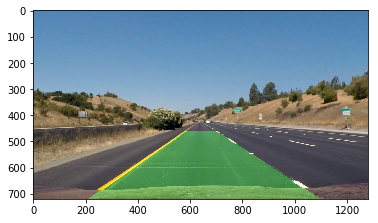

In [424]:
plt.imshow(img_with_lane)

#### 6b. Print curvatures and offset from center onto image

In [425]:
img_with_lane = cv2.putText(img_with_lane, 'Left lane line curvature: {:.2f} m'.format(left_curverad), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
img_with_lane = cv2.putText(img_with_lane, 'Right lane line curvature: {:.2f} m'.format(right_curverad), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
# Display car offset
img_with_lane = cv2.putText(img_with_lane, 'Horizontal car offset: {:.2f} m'.format((out_img.shape[1]//2-(right_fitx[-1]+left_fitx[-1])/2)*3.7/700), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)

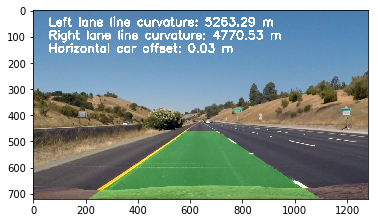

In [426]:
plt.imshow(img_with_lane)